## Model and Feature Selection

### Notebook Contents:

- [Reading in the Data](#reading)
- [Defining X and y](#features)
- [Feature Heatmap](#heatmap)
- [Baseline Model](#baseline)
- [Pipeline: Random Forest](#forest)
- [Recursive Feature Elimination Method](#RFE)
- [Principal Component Analysis](#PCA)


In [5]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer

from sklearn.decomposition import PCA

<a class="anchor" id="reading"></a>

### Reading in the Data

In [6]:
# read the csv file with log scaled data
df = pd.read_csv('data/log_per_student.csv')

C:\Users\Anel Akiyanova\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df.head(2)

,leaid,name,stabbr,agchrt,v33,totalrev,tfedrev,c14,c15,c16,...,w01,w31,w61,v95,v02,k14,ce1,ce2,ce3,graduation rate
0,<<<<<<< HEAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2700001,MOUNTAIN IRON-BUHL,MN,3.0,507.0,9.684527,6.770554,5.84403,0.0,3.244194,...,6.04522,0.0,10.269527,5.972549,4.529392,5.201033,0.0,0.0,0.0,0.9355


In [8]:
df.columns = df.columns.str.lower() #make column names lower-case

In [9]:
df.set_index(df['leaid'], inplace = True) #set leaid column as index

In [10]:
dummies = pd.get_dummies(df['agchrt'], drop_first = True).astype('float64') # dummify agchrt column

In [11]:
df = pd.concat([df, dummies], axis = 1) # add to the dataframe

In [12]:
df.isnull().sum() # check for null values

leaid              0
name               3
stabbr             3
agchrt             3
v33                3
                  ..
ce2                3
ce3                3
graduation rate    3
2.0                0
3.0                0
Length: 133, dtype: int64

In [13]:
df.dropna(axis = 0, inplace = True) #drop null values

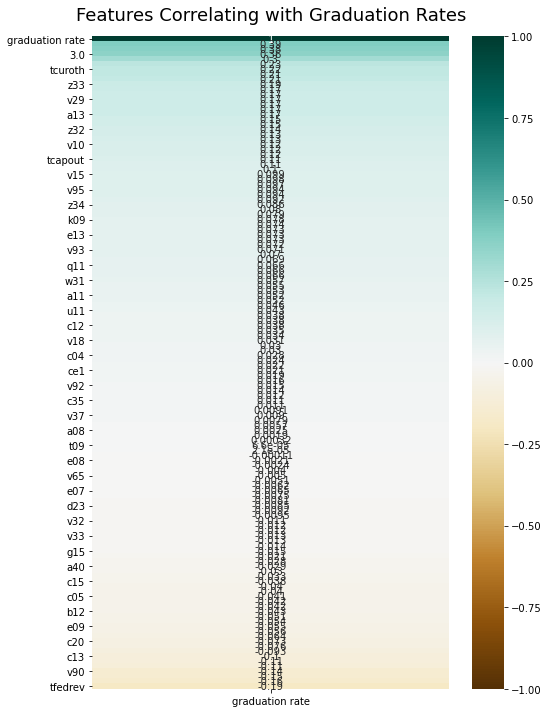

In [14]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['graduation rate']].sort_values(by='graduation rate', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Graduation Rates', fontdict={'fontsize':18}, pad=16);

Constructed and analyzed a heatmap to identify features that are highly correlated with the target. 

<a class="anchor" id="features"></a>

### Define X and y

In [15]:
# numeric X Features (excl stabbr)
X = df[[2, 3,'tfedrev', 'tstrev', 'a13', 't06', 'a11', 'u30', 'totalexp', 't40', 
        'v93', 'z33', 'z35', 'z36', 'z38', 'z37', 'v11', 'v13', 'v17', 'v37', 'v10', 'v12', 'v14', 
        'v18', 'v24', 'v38', 'w01', 'w31', 'w61', '_19h', '_21f', '_41f', '_61v']]

y = df['graduation rate']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y) #train test split the variables

In [17]:
# data types (the only object is district name column)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16848 entries, 2604950 to 4837710
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   2.0       16848 non-null  float64
 1   3.0       16848 non-null  float64
 2   tfedrev   16848 non-null  float64
 3   tstrev    16848 non-null  float64
 4   a13       16848 non-null  float64
 5   t06       16848 non-null  float64
 6   a11       16848 non-null  float64
 7   u30       16848 non-null  float64
 8   totalexp  16848 non-null  float64
 9   t40       16848 non-null  float64
 10  v93       16848 non-null  float64
 11  z33       16848 non-null  float64
 12  z35       16848 non-null  float64
 13  z36       16848 non-null  float64
 14  z38       16848 non-null  float64
 15  z37       16848 non-null  float64
 16  v11       16848 non-null  float64
 17  v13       16848 non-null  float64
 18  v17       16848 non-null  float64
 19  v37       16848 non-null  float64
 20  v10       16848 non-null 

<a class="anchor" id="heatmap"></a>

<a class="anchor" id="heatmap"></a>

#### Heatmap of numeric features

In [18]:
# creating a dataframe of features
feature_df = df[[2, 3,'tfedrev', 'tstrev', 'a13', 't06', 'a11', 'u30', 'totalexp', 't40', 
        'v93', 'z33', 'z35', 'z36', 'z38', 'z37', 'v11', 'v13', 'v17', 'v37', 'v10', 'v12', 'v14', 
        'v18', 'v24', 'v38', 'w01', 'w31', 'w61', '_19h', '_21f', '_41f', '_61v']]

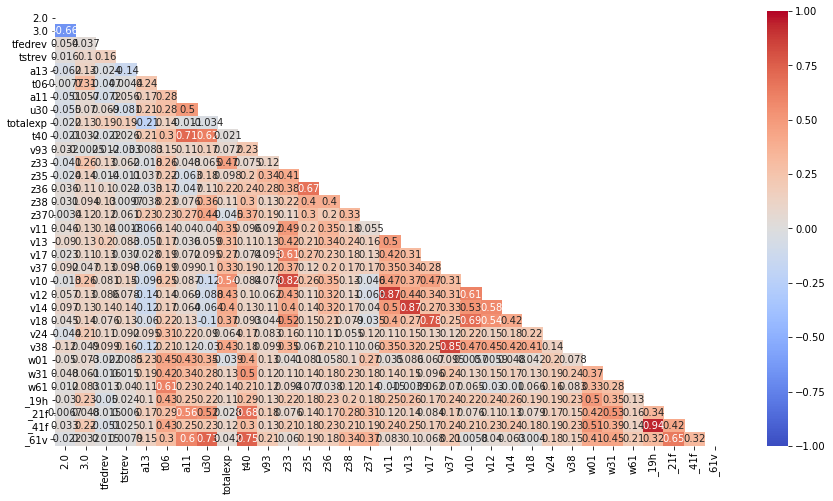

In [19]:
# plotting a heatmap / test for collinearity
mask = np.zeros_like(feature_df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 8))
sns.heatmap(
    feature_df.corr(),
    cmap='coolwarm',
    annot=True,
    mask = mask,
    vmin = -1.,
    vmax = 1.
    
);

Multicollinearity between featurs is observed. 

<a class="anchor" id="baseline"></a>

### Null Model

In [20]:
# baseline performance is ~14.5% off 
mean_y_array = np.full_like(y_test, y_test.mean())
np.round(mean_squared_error(y_test, mean_y_array, squared = False), 4)

0.1262

In [21]:
r2_score(y_test, mean_y_array)

3.3306690738754696e-16

<a class="anchor" id="forest"></a>

### Pipe: StandardScaler / RandomForest Regressor 

In [22]:
pipe_forest = make_pipeline(StandardScaler(), RandomForestRegressor()) #instantiate a pipe with RF

In [23]:
# fit the data
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [24]:
# score on the train data
pipe_forest.score(X_train, y_train)

0.9546224051863661

In [25]:
# score on the test (rsquared)
pipe_forest.score(X_test, y_test)

0.7274265301662199

In [26]:
# RMSE
np.round(mean_squared_error(y_test, pipe_forest.predict(X_test), squared = False), 4)

0.0659

In [27]:
# numeric features
float_feature_names = X.select_dtypes(['float64']).columns
int_feature_names = X.select_dtypes(['int64']).columns

In [28]:
# combine all features
names = list(float_feature_names) + list(int_feature_names)

<a class="anchor" id="RFE"></a>

#### Feature Selection with Random Forest

In [29]:
# instantiate RFE
rfe_forest = RFE(estimator = RandomForestRegressor(), n_features_to_select = 20, step = 1)

In [30]:
# make pipeline
pipe_rfe_forest = make_pipeline(StandardScaler(), rfe_forest, RandomForestRegressor())

In [31]:
# fit train data into the pipeline
pipe_rfe_forest.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=RandomForestRegressor(),
                     n_features_to_select=20)),
                ('randomforestregressor', RandomForestRegressor())])

In [32]:
rfe_forest.support_

array([False,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False,  True, False, False, False, False])

In [33]:
# coefficient rankings 
rankings_forest = rfe_forest.ranking_

In [34]:
# construct a dataframe with coefficients
rfe_forest_df = pd.DataFrame({'rankings' : rankings_forest, 'names' : names})

In [56]:
# display sorted values
rfe_forest_df.sort_values(by = 'rankings', inplace = True)
rfe_forest_df.head(20)

,rankings,names
16,1,v11
11,1,z33
1,1,3
2,1,tfedrev
4,1,a13
8,1,totalexp
28,1,w61
10,1,v93
13,1,z36
14,1,z38


<a class="anchor" id="PCA"></a>

#### Principal Component Analysis and RandomForest Regressor

In [36]:
sscaler = StandardScaler()

In [37]:
X_train_scaled = sscaler.fit_transform(X_train)

In [38]:
X_test_scaled = sscaler.transform(X_test)

In [39]:
# instantiate PCA
pca = PCA(random_state = 22)

In [40]:
# fit scaled X_train
X_train_pca = pca.fit_transform(X_train_scaled)

In [41]:
# fit scaled X_test
X_test_pca = pca.transform(X_test_scaled)

In [42]:
# explore explained variance of pca components
pca.explained_variance_

array([7.4584413 , 4.60270374, 1.9772547 , 1.94271236, 1.57967397,
       1.41802405, 1.37389303, 1.19134445, 1.08159538, 1.06196685,
       0.96015219, 0.8580379 , 0.82297327, 0.75719437, 0.73190006,
       0.65356736, 0.55856156, 0.5242112 , 0.47940729, 0.4469734 ,
       0.43905709, 0.35372952, 0.33385398, 0.26919723, 0.25396024,
       0.2134583 , 0.19237427, 0.17445739, 0.08757281, 0.06788477,
       0.05115282, 0.04634301, 0.03832892])

In [43]:
np.cumsum(pca.explained_variance_ratio_[:10])

array([0.22599996, 0.36546755, 0.4253808 , 0.48424738, 0.53211345,
       0.57508132, 0.61671197, 0.65281118, 0.68558485, 0.71776375])

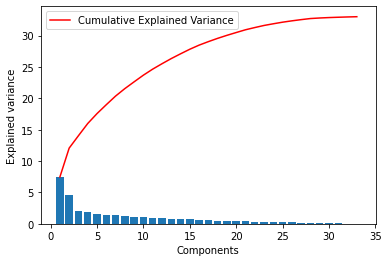

In [44]:
# plot cumulative explained variance 
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left');


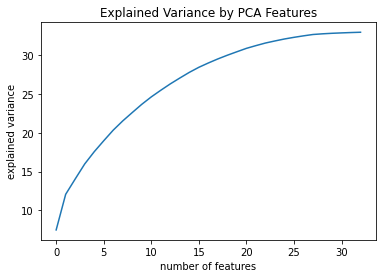

In [45]:
# plot explained variance
plt.plot(np.cumsum(pca.explained_variance_))
plt.title('Explained Variance by PCA Features')
plt.xlabel('number of features')
plt.ylabel('explained variance');

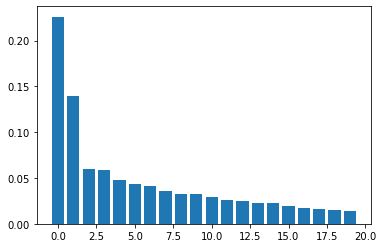

In [46]:
# explained variance 
plt.bar(range(20), pca.explained_variance_ratio_[:20]);

In [47]:
# fit pcad data into a RandomForest Regressor
rf = RandomForestRegressor()
rf.fit(X_train_pca, y_train)
rf.score(X_train_pca, y_train) # score on the train data

0.9131018126036258

In [48]:
# score on the test data
rf.score(X_test_pca, y_test)

0.36753263519814894

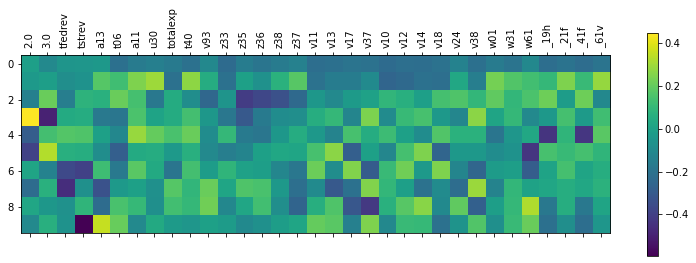

In [51]:
# plot first 10 principal components to see representation of the initial variables
plt.matshow(pca.components_[:10])
plt.xticks(range(33), X_train.columns, rotation = 90)
plt.colorbar()
plt.savefig('pca');

It looks that these features have the higher representation: Some but not all associated schools are charter
- No associated schools are charter
- Total Federal Revenue
- Total State Revenue
- Local Revenue - District Activity 
- Local Revenue - Textbook Sales
- Local Revenue - Fines and Forfeits
- Local Revenue - Individual and Corporate Income Taxes
- Teacher Salaries - Vocational Ed programs
- Teacher Salaries - support services - instructional staff
- Salaries - School Admin
- Salaries - business/ other
- Employee benefits - support services - instructional staff
- Employee benefits - support services - school admin
- Sinking Fund
- Other Funds
- Long term debt outstanding at beg of year
- Long terms debt - issued during fiscal year
- Long term debt outstanding at end of year
- Short term debt outstanding at beg of year
